In [1]:
#TEST IMPORTS
import numpy as np
from ours.V3_3 import Ours_V3_3 
from ours.V1 import Ours_V1
from cscg.cscg import CHMM, datagen_structured_obs_room

from envs.minigrid import GridWorldEnv
from visualisation_tools import *
import time
import pickle

## MINIGRID SETUP

In [2]:
# rooms = np.array(
#     [
#         [0, 0, 1],
#         [2, 0, 4],
#         [3, 3, 3],
#     ]
# )
rooms = np.array(
            [
                [0, 1, 2],
                [5, 4, 3],
                [6, 7, 8],
            ]
        ) 
# rooms = np.array(
#     [
#         [0, 0, 1, 4],
#         [2, 0, 1, 3],
#         [3, 3, 3, 0],
#     ]
# ) #3x4 rooms, 1 ob per room

# rooms = np.array(
#     [
#         [0, 1],
#         [2, 3]
#     ]
# )

In [3]:
#ASSIGN COLORS TO ROOMS IDS

custom_colors = (
    np.array(
        [
            [255, 0, 0],
            [0, 255, 0],
            [50,50, 255],
            [112, 39, 195],
            [255, 255, 0],
            [100, 100, 100],
            [0, 0, 0],
            [255, 255, 255],
            
        ]
    )
    / 256
)

cmap = create_custom_cmap(custom_colors[:len(np.unique(rooms))])

<AxesSubplot:>

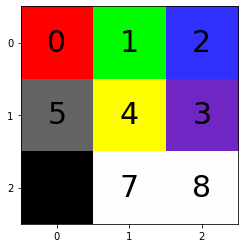

In [4]:
plot_map(rooms, cmap, show = True)

In [5]:
actions = {'LEFT':0, 'RIGHT':1,'UP':2, 'DOWN':3, 'STAY':4}
desired_state_mapping = {(i * rooms.shape[1] + j): (i, j) for i in range(rooms.shape[0]) for j in range(rooms.shape[1])}

In [6]:
def define_perfect_B(env,rooms, actions):
    """ The perfect B is defined as B[next_state, prev_state, action]"""
    #perfect B for this room config
    desired_state_mapping = {(i * rooms.shape[1] + j): (i, j) for i in range(rooms.shape[0]) for j in range(rooms.shape[1])}
    P = {}
    dim = rooms.shape
    for state_index, xy_coordinates in desired_state_mapping.items():
        P[state_index] = {a : [] for a in range(len(actions))}
        for action in actions.values():
            pose = env.next_p_given_a_known_env(xy_coordinates, action)
            #print('action', action, 'state coordinates', state_index, xy_coordinates, 'next pose', pose)
            next_state_idx = next(key for key, value in desired_state_mapping.items() if value == pose)
            P[state_index][action] = next_state_idx


    num_states = len(desired_state_mapping)
    B = np.zeros([num_states, num_states, len(actions)])
    # print(B.shape)
    for s in range(num_states):
        # print('s', s, perfect_state_mapping[s])
        for a in range(len(actions)):
            ns = int(P[s][a])
            # print('ps', s, 'a', a, 'ns',ns)
            B[ns, s, a] = 1
    return B, desired_state_mapping

def agent_B_match_ideal_B_v2(agent_B, perfect_B, agent_state_mapping, desired_state_mapping, actions, tolerance_margin = 0.3):
    """Check if the values == 1 in perfect_B are filled with values relatively close at tolerance level"""
    room_valid_state_agent= { k:v for k, v in agent_state_mapping.items() if k in desired_state_mapping.values() }

    if len(room_valid_state_agent) < len(desired_state_mapping):
        return False
    rearranged_B = B_to_ideal_B(agent_B, actions,desired_state_mapping, room_valid_state_agent)
    rearranged_B = rearranged_B[:len(desired_state_mapping),:len(desired_state_mapping),:]
    if rearranged_B.shape != perfect_B.shape:
        raise 'rearranged_B.shape should match B.shape'
    non_zero_mask = perfect_B > 0
    matching_indices = np.where(non_zero_mask & (np.abs(perfect_B - rearranged_B) <= tolerance_margin))
    match_result = np.array_equal(np.array(matching_indices) ,np.array(np.where(non_zero_mask)))
    
    return match_result

In [7]:
#TEST MODELS INIT

env = GridWorldEnv('grid_3x3', actions)
start_pose = (0,0)
ob = env.reset(start_pose)
start_state_idx = env.get_state(start_pose)

## LOAD MODELS

In [8]:
def load_object(load_path):            
    with open(load_path, "rb") as inp:
        agent = pickle.load(inp)
    return agent


In [9]:
from bokeh.plotting import show, output_file, figure
from bokeh.layouts import column, row
from bokeh.models import Div
from bokeh.models.widgets import Panel, Tabs

In [10]:
import imageio
def generate_run_report(run_logs, store_path):
    figures = []

    state_beliefs = [log["qs"] for log in run_logs["agent_info"]]

    # Trajectory gif
    gif_path = store_path / "navigate.gif"
    imageio.mimsave(gif_path, run_logs["frames"], 'GIF', duration=500)

    h, w, _ = run_logs["frames"][0].shape
    h = max(128, h)
    w = max(128, w)
    gif = Div(
        text=f"<img src={str(gif_path)} width={w} height={h}></img>",
        width=w,
        height=h,
    )
    figures.append(gif)
    # Entropy plot
    entropies = [entropy(s) for s in state_beliefs]
    fig_entropy = figure(title="Entropy over full state belief", plot_height=200)
    fig_entropy.line(np.arange(len(entropies)), entropies)
    figures.append(fig_entropy)

    # Bayesian Surprise
    surprises = [np.nan_to_num(log["bayesian_surprise"]) for log in run_logs["agent_info"]]
    fig_surprise = figure(title="Bayesian Surprise", plot_height=200)
    fig_surprise.line(np.arange(len(surprises)), surprises)
    figures.append(fig_surprise)

    return row(*figures)

In [11]:
output_file("report.html")

generate_run_report(data_infos, spath)
#show(layout)

NameError: name 'data_infos' is not defined

ValueError: not enough values to unpack (expected 2, got 1)

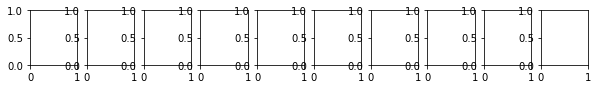

In [ ]:
# from bokeh.models.widgets import Image
from bokeh.io import curdoc

pages = []

spath = get_store_path('cscg', 'test')

spath.mkdir(exist_ok=True, parents=True)


run_logs = {'here':[1,2,3,3,4]}

run_logs['test'] =  ['mia' for _ in run_logs["here"]]

run_logs_df = pd.DataFrame.from_dict(run_logs)

codebook_path = spath / "codebook.png"
n = int(np.ceil(len(run_logs_df['here']) / 10))
w, h = 1000, n *100
# Create an Image widget to display the codebook image
#codebook_img = Div(text=f"<img src='{str(codebook_path)}' width='{w}' height='{h}'>")

codebook = Div(
    text=f"<img src={str(codebook_path)} width={w} height={h}></img>",
    width=w,
    height=h,
)

page = column(
    Div(text=f"{'tutu'}-{'big'}"),
    generate_run_report(data_infos, spath),
    #codebook_img
)
pages.append(
    Panel(child=page, title=f"{'cscg'}: Trial {'1'}")
)

title_path = spath / "cscg_test.html"
output_file(
        title_path,
        title='test_cscg'.capitalize(),
    )

title = Div(text=f"<h1>Report for {'test_cscg'}</h1>")

#curdoc().add_root(column(title, Tabs(tabs=pages)))
show(column(title, codebook, Tabs(tabs=pages)))

run_logs_df.to_csv(spath / f"{'test'}.csv")

## OURS

In [12]:
ours_v3_3 = Ours_V3_3(num_obs=2, num_states=2, observations=[ob,start_pose], learning_rate_pB=3.0, actions= actions)
#ours_v1 = Ours_V1(num_obs=2, num_states=2, observations=[ob,start_state_idx], learning_rate_pB=3.0, actions= actions)
action_hist = []

 __ 
time 0 believed Qs: [1. 0.]


/home/idlab332/workspace/higher_level_nav/ours/pymdp/utils.py:21: RuntimeWarning: invalid value encountered in true_divide
  return (posterior * np.log(posterior / prior)).sum()


action taken: 3 pose: (1, 0) ,ob: 5
prior on believed state [0. 1.]
update_B: a 3 qs[factor] [0. 1.] qs_prev[factor] [1. 0.]
update_B: a 2 qs[factor] [1. 0.] qs_prev[factor] [0. 1.]
Ghost nodes process:
update_B: a 0 qs[factor] [0. 1.] qs_prev[factor] [0. 1.]
a 1 n pose (1, 1) 2
update_B: a 1 qs[factor] [0.016 0.016 0.968] qs_prev[factor] [0. 1. 0.]
a 3 n pose (2, 0) 3
update_B: a 3 qs[factor] [0.125 0.125 0.083 0.667] qs_prev[factor] [0. 1. 0. 0.]
after belief update
A colours:
 [[0.    0.056 0.167 0.167]
 [0.    0.056 0.167 0.167]
 [0.    0.056 0.167 0.167]
 [0.    0.056 0.167 0.167]
 [0.    0.056 0.167 0.167]
 [1.    0.722 0.167 0.167]]
A poses:
 [[1.    0.167 0.    0.   ]
 [0.    0.833 0.    0.   ]
 [0.167 0.167 1.    0.   ]
 [0.125 0.125 0.125 1.   ]]
B
          LEFT
    prev_s   
       0      1      2     3
0  0.316  0.043  0.267  0.25
1  0.316  0.906  0.267  0.25
2  0.211  0.029  0.267  0.25
3  0.158  0.022  0.200  0.25
          RIGHT
    prev_s   
       0      1      2     

/home/idlab332/workspace/higher_level_nav/ours/pymdp/utils.py:21: RuntimeWarning: invalid value encountered in true_divide
  return (posterior * np.log(posterior / prior)).sum()


action taken: 3 pose: (2, 0) ,ob: 6
prior on believed state [0.043 0.043 0.029 0.885]
update_B: a 3 qs[factor] [0.043 0.043 0.029 0.885] qs_prev[factor] [0. 1. 0. 0.]
update_B: a 2 qs[factor] [0. 1. 0. 0.] qs_prev[factor] [0.043 0.043 0.029 0.885]
Ghost nodes process:
update_B: a 0 qs[factor] [0.014 0.014 0.009 0.962] qs_prev[factor] [0.014 0.014 0.009 0.962]
a 1 n pose (2, 1) 4
update_B: a 1 qs[factor] [0.011 0.017 0.011 0.015 0.946] qs_prev[factor] [0.014 0.014 0.009 0.962 0.   ]
update_B: a 3 qs[factor] [0.014 0.014 0.009 0.962 0.   ] qs_prev[factor] [0.014 0.014 0.009 0.962 0.   ]
after belief update
A colours:
 [[0.    0.051 0.153 0.056 0.143]
 [0.    0.051 0.153 0.056 0.143]
 [0.    0.051 0.153 0.056 0.143]
 [0.    0.051 0.153 0.056 0.143]
 [0.    0.051 0.153 0.056 0.143]
 [0.909 0.657 0.153 0.056 0.143]
 [0.091 0.091 0.083 0.666 0.143]]
A poses:
 [[0.758 0.126 0.    0.    0.   ]
 [0.    0.631 0.    0.    0.   ]
 [0.126 0.126 0.874 0.    0.   ]
 [0.116 0.116 0.126 1.    0.   ]
 [

/home/idlab332/workspace/higher_level_nav/ours/pymdp/utils.py:21: RuntimeWarning: invalid value encountered in true_divide
  return (posterior * np.log(posterior / prior)).sum()


action taken: 1 pose: (2, 1) ,ob: 7
prior on believed state [0.01  0.011 0.011 0.01  0.958]
update_B: a 1 qs[factor] [0.01  0.011 0.011 0.01  0.958] qs_prev[factor] [0.014 0.014 0.009 0.962 0.   ]
update_B: a 0 qs[factor] [0.014 0.014 0.009 0.962 0.   ] qs_prev[factor] [0.01  0.011 0.011 0.01  0.958]
Ghost nodes process:
a 1 n pose (2, 2) 5
update_B: a 1 qs[factor] [0.009 0.009 0.01  0.009 0.01  0.953] qs_prev[factor] [0.004 0.004 0.005 0.004 0.984 0.   ]
update_B: a 3 qs[factor] [0.004 0.004 0.005 0.004 0.984 0.   ] qs_prev[factor] [0.004 0.004 0.005 0.004 0.984 0.   ]
after belief update
A colours:
 [[0.    0.047 0.143 0.052 0.047 0.125]
 [0.    0.047 0.143 0.052 0.047 0.125]
 [0.    0.047 0.143 0.052 0.047 0.125]
 [0.    0.047 0.143 0.052 0.047 0.125]
 [0.    0.047 0.143 0.052 0.047 0.125]
 [0.85  0.613 0.143 0.052 0.047 0.125]
 [0.085 0.085 0.077 0.623 0.047 0.125]
 [0.066 0.066 0.067 0.065 0.67  0.125]]
A poses:
 [[0.684 0.114 0.    0.    0.    0.   ]
 [0.    0.57  0.    0.    0. 

/home/idlab332/workspace/higher_level_nav/ours/pymdp/utils.py:21: RuntimeWarning: invalid value encountered in true_divide
  return (posterior * np.log(posterior / prior)).sum()


action taken: 2 pose: (1, 1) ,ob: 4
prior on believed state [0.    0.047 0.953 0.    0.    0.   ]
update_B: a 2 qs[factor] [0.    0.047 0.953 0.    0.    0.   ] qs_prev[factor] [0.004 0.004 0.005 0.004 0.984 0.   ]
update_B: a 3 qs[factor] [0.004 0.004 0.005 0.004 0.984 0.   ] qs_prev[factor] [0.    0.047 0.953 0.    0.    0.   ]
Ghost nodes process:
a 1 n pose (1, 2) 6
update_B: a 1 qs[factor] [0.062 0.088 0.07  0.046 0.037 0.031 0.667] qs_prev[factor] [0.    0.004 0.996 0.    0.    0.    0.   ]
a 2 n pose (0, 1) 7
update_B: a 2 qs[factor] [0.058 0.082 0.064 0.043 0.034 0.028 0.024 0.667] qs_prev[factor] [0.    0.004 0.996 0.    0.    0.    0.    0.   ]
after belief update
A colours:
 [[0.    0.047 0.048 0.052 0.047 0.125 0.125 0.125]
 [0.    0.047 0.048 0.052 0.047 0.125 0.125 0.125]
 [0.    0.047 0.048 0.052 0.047 0.125 0.125 0.125]
 [0.    0.047 0.048 0.052 0.047 0.125 0.125 0.125]
 [0.    0.054 0.714 0.052 0.047 0.125 0.125 0.125]
 [0.85  0.609 0.048 0.052 0.047 0.125 0.125 0.125]

/home/idlab332/workspace/higher_level_nav/ours/pymdp/utils.py:21: RuntimeWarning: invalid value encountered in true_divide
  return (posterior * np.log(posterior / prior)).sum()


action taken: 0 pose: (1, 0) ,ob: 5
prior on believed state [0. 1. 0. 0. 0. 0. 0. 0.]
update_B: a 0 qs[factor] [0. 1. 0. 0. 0. 0. 0. 0.] qs_prev[factor] [0.    0.004 0.996 0.    0.    0.    0.    0.   ]
update_B: a 1 qs[factor] [0.    0.004 0.996 0.    0.    0.    0.    0.   ] qs_prev[factor] [0. 1. 0. 0. 0. 0. 0. 0.]
Ghost nodes process:
update_B: a 0 qs[factor] [0. 1. 0. 0. 0. 0. 0. 0.] qs_prev[factor] [0. 1. 0. 0. 0. 0. 0. 0.]
after belief update
A colours:
 [[0.    0.016 0.048 0.052 0.047 0.125 0.125 0.125]
 [0.    0.016 0.048 0.052 0.047 0.125 0.125 0.125]
 [0.    0.016 0.048 0.052 0.047 0.125 0.125 0.125]
 [0.    0.016 0.048 0.052 0.047 0.125 0.125 0.125]
 [0.    0.018 0.714 0.052 0.047 0.125 0.125 0.125]
 [0.85  0.87  0.048 0.052 0.047 0.125 0.125 0.125]
 [0.085 0.028 0.026 0.623 0.047 0.125 0.125 0.125]
 [0.066 0.022 0.022 0.065 0.67  0.125 0.125 0.125]]
A poses:
 [[0.557 0.033 0.    0.    0.    0.    0.    0.   ]
 [0.    0.805 0.    0.    0.    0.    0.    0.   ]
 [0.093 0.035

/home/idlab332/workspace/higher_level_nav/ours/pymdp/utils.py:21: RuntimeWarning: invalid value encountered in true_divide
  return (posterior * np.log(posterior / prior)).sum()


action taken: 0 pose: (0, 0) ,ob: 0
prior on believed state [0. 1. 0. 0. 0. 0. 0. 0. 0.]
update_B: a 0 qs[factor] [0. 1. 0. 0. 0. 0. 0. 0. 0.] qs_prev[factor] [0.    0.    0.    0.001 0.001 0.001 0.001 0.996 0.   ]
update_B: a 1 qs[factor] [0.    0.    0.    0.001 0.001 0.001 0.001 0.996 0.   ] qs_prev[factor] [0. 1. 0. 0. 0. 0. 0. 0. 0.]
Ghost nodes process:
update_B: a 0 qs[factor] [0. 1. 0. 0. 0. 0. 0. 0. 0.] qs_prev[factor] [0. 1. 0. 0. 0. 0. 0. 0. 0.]
update_B: a 2 qs[factor] [0. 1. 0. 0. 0. 0. 0. 0. 0.] qs_prev[factor] [0. 1. 0. 0. 0. 0. 0. 0. 0.]
after belief update
A colours:
 [[0.    0.672 0.016 0.052 0.047 0.125 0.125 0.042 0.125]
 [0.    0.005 0.016 0.054 0.048 0.128 0.127 0.707 0.125]
 [0.    0.005 0.016 0.052 0.047 0.125 0.125 0.042 0.125]
 [0.    0.005 0.016 0.052 0.047 0.125 0.125 0.042 0.125]
 [0.    0.006 0.904 0.052 0.047 0.125 0.125 0.042 0.125]
 [0.85  0.29  0.016 0.052 0.047 0.125 0.125 0.042 0.125]
 [0.085 0.009 0.009 0.622 0.047 0.125 0.125 0.042 0.125]
 [0.066 0

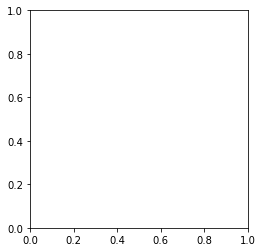

In [ ]:
# #RUN oursV3.3 EXPLO
T= 45
perfect_B, desired_state_mapping = define_perfect_B(env,rooms, actions)
pose = start_pose
ours_v3_3.explo_oriented_navigation()
data_infos = {'frames':[get_frame(env, pose)], 'agent_info':[]}
#policy = [0,3,4,1]
for t in range(0,T):
    print(' __ ')
    print('time', t, 'believed Qs:',ours_v3_3.get_current_belief()[0].round(3))
    action, info = ours_v3_3.infer_action()
    # action = policy[t]
    # ours_v3_3.agent.action = np.array([action])
    # ours_v3_3.agent.step_time()
    action_hist.append(action)
    ob, pose = env.step(action, pose)
    data = {}
    data_infos['frames'].append(get_frame(env, pose))
    # data_infos['agent_info'].append(info)
    
    next_possible_actions = env.get_next_possible_motions(pose)
    print('action taken:',int(action),'pose:',pose,',ob:', ob)
    ours_v3_3.agent_step_update(action,[ob,pose],next_possible_actions)
    
    print('after belief update')
    print('A colours:\n',ours_v3_3.agent.A[0].round(3))
    print('A poses:\n',ours_v3_3.agent.A[1].round(3))
    print('B')
    print_transitions(ours_v3_3.agent.B, actions)
    
    if agent_B_match_ideal_B_v2(ours_v3_3.get_B(), perfect_B, \
                ours_v3_3.get_agent_state_mapping(), \
                desired_state_mapping, actions, tolerance_margin= 0.4):
            print('Transition matrix is good')
            break

In [16]:
ours_v3_3 = load_object("/home/idlab332/workspace/higher_level_nav/results/grid_3x3/ours_v3/ours_v3_2024-01-29-14-40-42/ours_v3.pkl")

In [17]:
preferred_ob = [4, -1]
ours_v3_3.goal_oriented_navigation(obs = preferred_ob.copy())

In [19]:
# # #RUN oursV3.3 GOAL
action_hist = []
T= 10
pose = start_pose
c_ob = []
p_ob = []
for t in range(0,T):
    print(' __ ')
    print('time', t, 'believed Qs:',ours_v3_3.get_current_belief()[0].round(3))
    action, _ = ours_v3_3.infer_action()
    action_hist.append(action)
    ob, pose = env.step(action, pose)
    c_ob.append(ob)
    p_ob.append(pose)
    next_possible_actions = env.get_next_possible_motions(pose, no_stay = True)
    print('action taken:',int(action),'pose:',pose,',ob:', ob)
    print('next_possible_actions',next_possible_actions)
    ours_v3_3.agent_step_update(action,[ob,pose],next_possible_actions)
    
    if (ob == preferred_ob[0] and action == actions['STAY']) \
        or (preferred_ob[0] == np.all(c_ob[-3:]) and pose == np.all(p_ob[-3:])) :
        print('Goal reached')
        break

 __ 
time 0 believed Qs: [0. 0. 0. 0. 0. 0. 0. 1. 0.]
C [array([0., 0., 0., 0., 1., 0., 0., 0., 0.])
 array([0., 0., 0., 0., 0., 0., 0., 0., 0.])] 0 [array([0., 0., 0., 0., 1., 0., 0., 0., 0.])
 array([0., 0., 0., 0., 0., 0., 0., 0., 0.])] [0. 0. 0. 0. 1. 0. 0. 0. 0.] 4
C [array([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [1., 1., 1., 1.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]]) array([0., 0., 0., 0., 0., 0., 0., 0., 0.])] 1 [array([0., 0., 0., 0., 1., 0., 0., 0., 0.])
 array([0., 0., 0., 0., 0., 0., 0., 0., 0.])] [0. 0. 0. 0. 0. 0. 0. 0. 0.] 4
C [array([0., 0., 0., 0., 1., 0., 0., 0., 0.])
 array([0., 0., 0., 0., 0., 0., 0., 0., 0.])] 0 [array([0., 0., 0., 0., 1., 0., 0., 0., 0.])
 array([0., 0., 0., 0., 0., 0., 0., 0., 0.])] [0. 0. 0. 0. 1. 0. 0. 0. 0.] 4
C [array([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],


<AxesSubplot:>

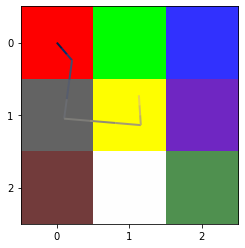

In [20]:
plot_path_in_map(env, start_pose, action_hist[:])

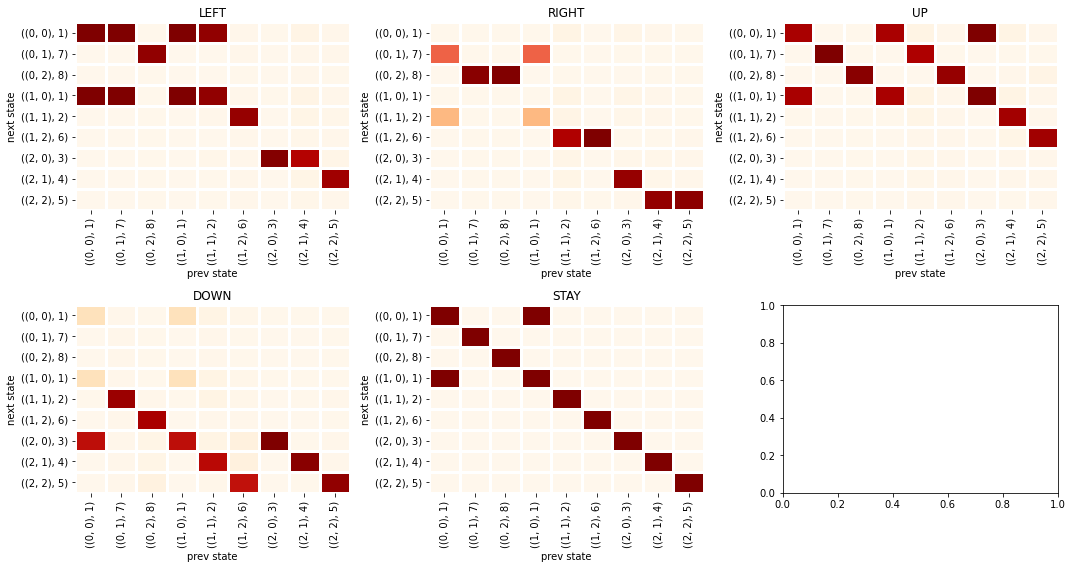

In [ ]:
plot_transition_detailed(ours_v3_3.get_B(), actions, ours_v3_3.get_agent_state_mapping(), desired_state_mapping, 'ours_v3_3', plot=True, save=False)

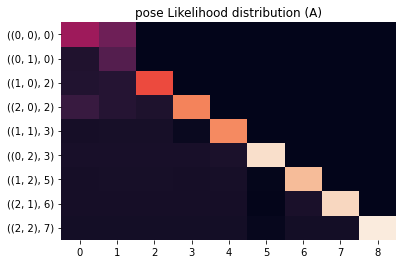

In [ ]:
plot_likelihood(ours_v3_3.get_A()[1], state_mapping=ours_v3_3.get_agent_state_mapping(), tittle_add='pose')

In [ ]:
a = print_transitions(ours_v3_3.get_B(), actions)

          UP
    prev_s   
       0      1      2      3      4      5      6      7      8
0  0.877  0.661  0.874  0.118  0.095  0.078  0.070  0.010  0.111
1  0.107  0.240  0.072  0.102  0.069  0.051  0.024  0.023  0.111
2  0.003  0.014  0.008  0.096  0.059  0.041  0.005  0.024  0.111
3  0.007  0.054  0.029  0.399  0.552  0.535  0.884  0.025  0.111
4  0.002  0.008  0.005  0.076  0.058  0.040  0.003  0.067  0.111
5  0.002  0.007  0.004  0.064  0.049  0.040  0.005  0.847  0.111
6  0.001  0.006  0.003  0.054  0.042  0.034  0.003  0.001  0.111
7  0.001  0.005  0.003  0.048  0.036  0.030  0.003  0.001  0.111
8  0.001  0.005  0.003  0.044  0.040  0.152  0.003  0.001  0.111
          RIGHT
    prev_s   
       0      1      2      3      4      5      6      7      8
0  0.487  0.392  0.098  0.189  0.070  0.001  0.014  0.001  0.111
1  0.421  0.375  0.058  0.185  0.070  0.001  0.014  0.001  0.111
2  0.017  0.031  0.035  0.156  0.070  0.001  0.015  0.001  0.111
3  0.040  0.120  0.799  0.160  0.

## CSCG

In [ ]:
n_emissions = rooms.max() + 1
n_clones = np.ones(n_emissions, dtype=np.int64) * 10
n_actions = max(list(actions.values()))
x = np.array([0])
a = np.array([n_actions])
chmm  =  CHMM(n_clones=n_clones, pseudocount=0.002, \
                x=x, a=a, seed=42, set_stationary_B=True) 

In [ ]:
#CSCG EXPLORATION
T=300
ob = env.get_ob_given_p(start_pose)
x, a = [np.array([ob],dtype=np.int64), np.array([], dtype=np.int64)]
poses = [start_pose]
pose = start_pose
for t in range(0,T):
    next_possible_actions = env.get_next_possible_motions(pose, no_stay=False)
    # print('p next actions', pose, next_possible_actions)
    next_possible_actions = [0,1,2,3]
    action, _ = chmm.infer_action(next_possible_actions = next_possible_actions, observation=ob, random_policy=False)
    ob, pose = env.step(action, pose)
    x =np.append(x,ob)
    a= np.append(a,action)
    poses.append(pose)

progression = chmm.learn_em_T(x, a, n_iter=200)  # Training

# refine learning
chmm.pseudocount = 0.0001

chmm.learn_viterbi_T(x, a, n_iter=100)


 48%|████▊     | 96/200 [00:08<00:08, 11.72it/s, train_bps=0.0453]

here (5, 90, 90)



  2%|▏         | 2/100 [00:04<03:42,  2.27s/it, train_bps=0.0231]


ValueError: could not broadcast input array from shape (5,5) into shape (90,90)

In [ ]:
print('here',chmm.T[-1,:,:].shape)

here (90, 90)


In [ ]:
poses

[(0, 0),
 (0, 0),
 (0, 1),
 (0, 1),
 (1, 1),
 (2, 1),
 (2, 0),
 (1, 0),
 (1, 1),
 (1, 2),
 (2, 2),
 (1, 2),
 (1, 2),
 (0, 2),
 (0, 2),
 (0, 1),
 (0, 2),
 (0, 1),
 (0, 2),
 (0, 2),
 (0, 2),
 (1, 2),
 (0, 2),
 (0, 2),
 (0, 1),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 1),
 (0, 1),
 (0, 0),
 (1, 0),
 (1, 1),
 (1, 0),
 (0, 0),
 (0, 0),
 (1, 0),
 (1, 0),
 (1, 1),
 (1, 0),
 (0, 0),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 0),
 (1, 0),
 (0, 0),
 (0, 0),
 (0, 1),
 (1, 1),
 (0, 1),
 (0, 1),
 (0, 2),
 (0, 1),
 (0, 1),
 (0, 2),
 (0, 2),
 (0, 1),
 (1, 1),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 1),
 (0, 1),
 (1, 1),
 (1, 2),
 (1, 1),
 (2, 1),
 (2, 0),
 (2, 0),
 (2, 0),
 (2, 0),
 (1, 0),
 (1, 0),
 (0, 0),
 (1, 0),
 (2, 0),
 (2, 0),
 (1, 0),
 (0, 0),
 (0, 0),
 (0, 1),
 (0, 2),
 (1, 2),
 (2, 2),
 (2, 2),
 (2, 2),
 (2, 2),
 (2, 1),
 (2, 0),
 (2, 0),
 (2, 0),
 (2, 0),
 (2, 0),
 (2, 0),
 (1, 0),
 (2, 0),
 (1, 0),
 (2, 0),
 (2, 0),
 (2, 0),
 (2, 0),
 (1, 0),
 (0, 0),
 (0, 0),
 (1, 0),
 (0, 0),
 (0, 1),
 

In [ ]:
with open("figures/cscg/cscg_test.pkl", "wb") as outp:
    pickle.dump(chmm, outp, pickle.HIGHEST_PROTOCOL)

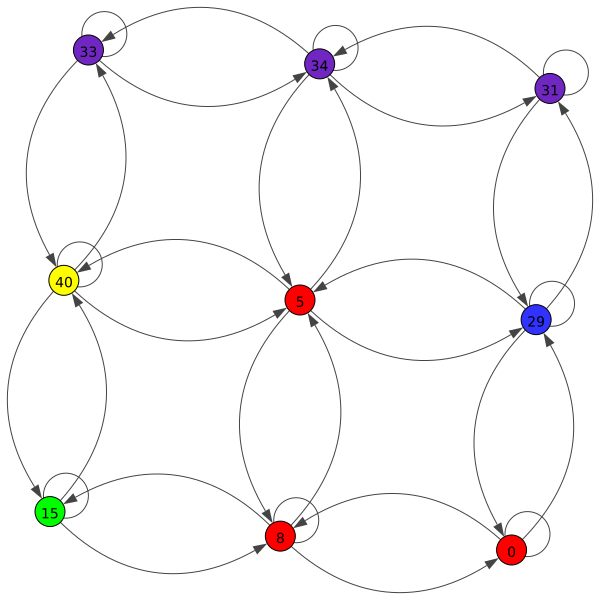

In [ ]:
if len(chmm.states) == 0:
    states = chmm.decode(x,a[1:])[1]
else:
    states = chmm.states
    v = np.unique(states)
    T = chmm.C[:, v][:, :, v]
    A = T.sum(0)
    div = A.sum(1, keepdims=True)
    A /= (div + 0.0001)
cwd = Path.cwd()
graph = plot_cscg_graph(A, x, v, chmm.n_clones,  cwd, cmap)

graph


In [ ]:
def plot_path_in_map_here(env, pose, policy=None):
    if policy is None:
        agent_poses = pose
        # random_values_x = np.random.randint(-50, 50, size=len(x)) / 100
        # random_values_y = np.random.randint(-50, 50, size=len(y)) / 100
        # # add random values to the list
        # x = [xn + rx for xn, rx in zip(x, random_values_x)]
        # y = [yn + ry for yn, ry in zip(y, random_values_y)]
    else:
        agent_poses, obs = from_policy_to_pose(env, pose, policy, add_rand=True)
    ax = plot_map(env.rooms, env.rooms_colour_map, show=False)
    agent_poses = np.vstack(agent_poses)
    path = mpath.Path(np.column_stack([agent_poses[:,1], agent_poses[:,0]]))
    verts = path.interpolated(steps=3).vertices
    x, y = verts[:, 0], verts[:, 1]
    z = np.linspace(0, 1, len(x))
    colorline(x, y, z, cmap=plt.get_cmap('cividis'), linewidth=2, ax=ax)
    # plot_name = 'figures/'+ model_name + '/room_'+str(env.rooms.shape[0])+'x'+str(env.rooms.shape[1])+'_'+str(np.max(env.rooms))+'obs_0'
    # count = 0
    # while os.path.exists(plot_name+'.jpg'):
    #     count+=1
    #     plot_name = plot_name.replace('obs_'+str(count-1), 'obs_'+str(count))
    #try:
    #     plt.savefig(plot_name +'.jpg')
    # except FileNotFoundError:
    #     print('the path to figures is inexistant to save the plot_path_in_map')
    return ax

<AxesSubplot:>

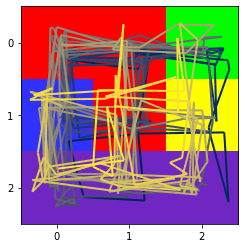

In [ ]:
plot_path_in_map(env, start_pose, a[:], cmap, 'cscg')

In [ ]:
agent_state_mapping = chmm.get_agent_state_mapping(x,a,poses )
agent_state_mapping

{(2, 0): {'state': 31, 'ob': 3},
 (2, 1): {'state': 34, 'ob': 3},
 (1, 1): {'state': 5, 'ob': 0},
 (1, 2): {'state': 40, 'ob': 4},
 (0, 2): {'state': 15, 'ob': 1},
 (0, 1): {'state': 8, 'ob': 0},
 (1, 0): {'state': 26, 'ob': 2},
 (2, 2): {'state': 33, 'ob': 3},
 (0, 0): {'state': 0, 'ob': 0}}

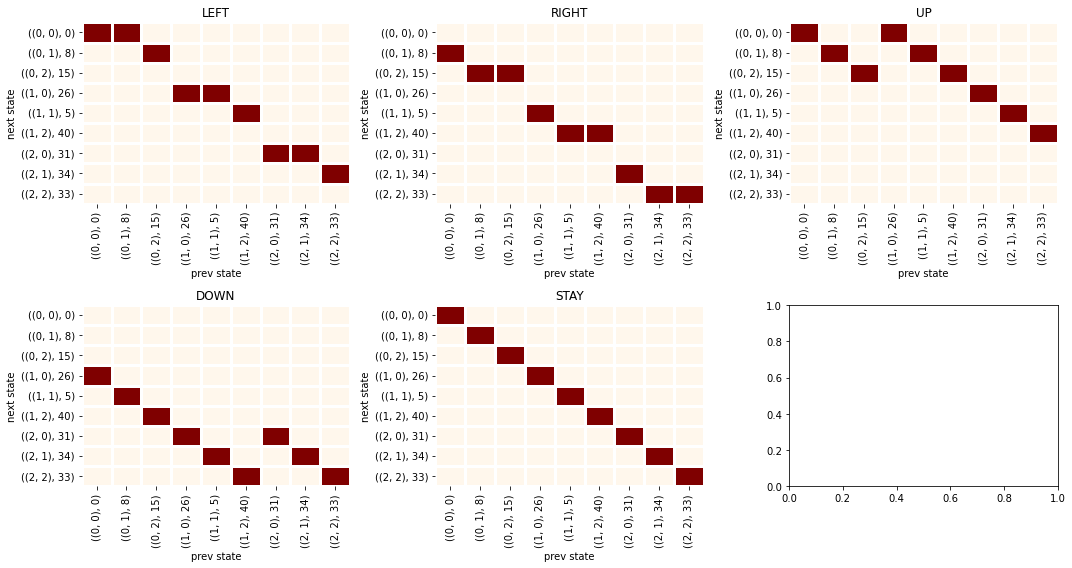

In [ ]:
n_states =  9#chmm.get_n_states()
plot_transition_detailed_resized(chmm.get_B(), actions, n_states,agent_state_mapping, \
                             desired_state_mapping, 'cscg', plot=True, save=False)

In [ ]:
tr = print_transitions(chmm.get_B(), actions)

          UP
    prev_s   
     0     1     2     3     4      5     6     7      8     9   ...     40  \
0   1.0  0.02  0.02  0.02  0.02  0.000  0.02  0.02  0.000  0.02  ...  0.000   
1   0.0  0.02  0.02  0.02  0.02  0.000  0.02  0.02  0.000  0.02  ...  0.000   
2   0.0  0.02  0.02  0.02  0.02  0.000  0.02  0.02  0.000  0.02  ...  0.000   
3   0.0  0.02  0.02  0.02  0.02  0.000  0.02  0.02  0.000  0.02  ...  0.000   
4   0.0  0.02  0.02  0.02  0.02  0.000  0.02  0.02  0.000  0.02  ...  0.000   
5   0.0  0.02  0.02  0.02  0.02  0.000  0.02  0.02  0.000  0.02  ...  0.000   
6   0.0  0.02  0.02  0.02  0.02  0.000  0.02  0.02  0.000  0.02  ...  0.000   
7   0.0  0.02  0.02  0.02  0.02  0.000  0.02  0.02  0.000  0.02  ...  0.000   
8   0.0  0.02  0.02  0.02  0.02  0.999  0.02  0.02  0.999  0.02  ...  0.000   
9   0.0  0.02  0.02  0.02  0.02  0.000  0.02  0.02  0.000  0.02  ...  0.000   
10  0.0  0.02  0.02  0.02  0.02  0.000  0.02  0.02  0.000  0.02  ...  0.000   
11  0.0  0.02  0.02  0.02

In [ ]:
preferred_ob = [4, -1]
chmm = load_object("/home/idlab332/workspace/higher_level_nav/results/grid_3x3/cscg/cscg_2024-01-26-17-24-46/cscg.pkl")


chmm.goal_oriented_navigation(obs = preferred_ob.copy())

(5, 90, 90)
(90, 90, 5)


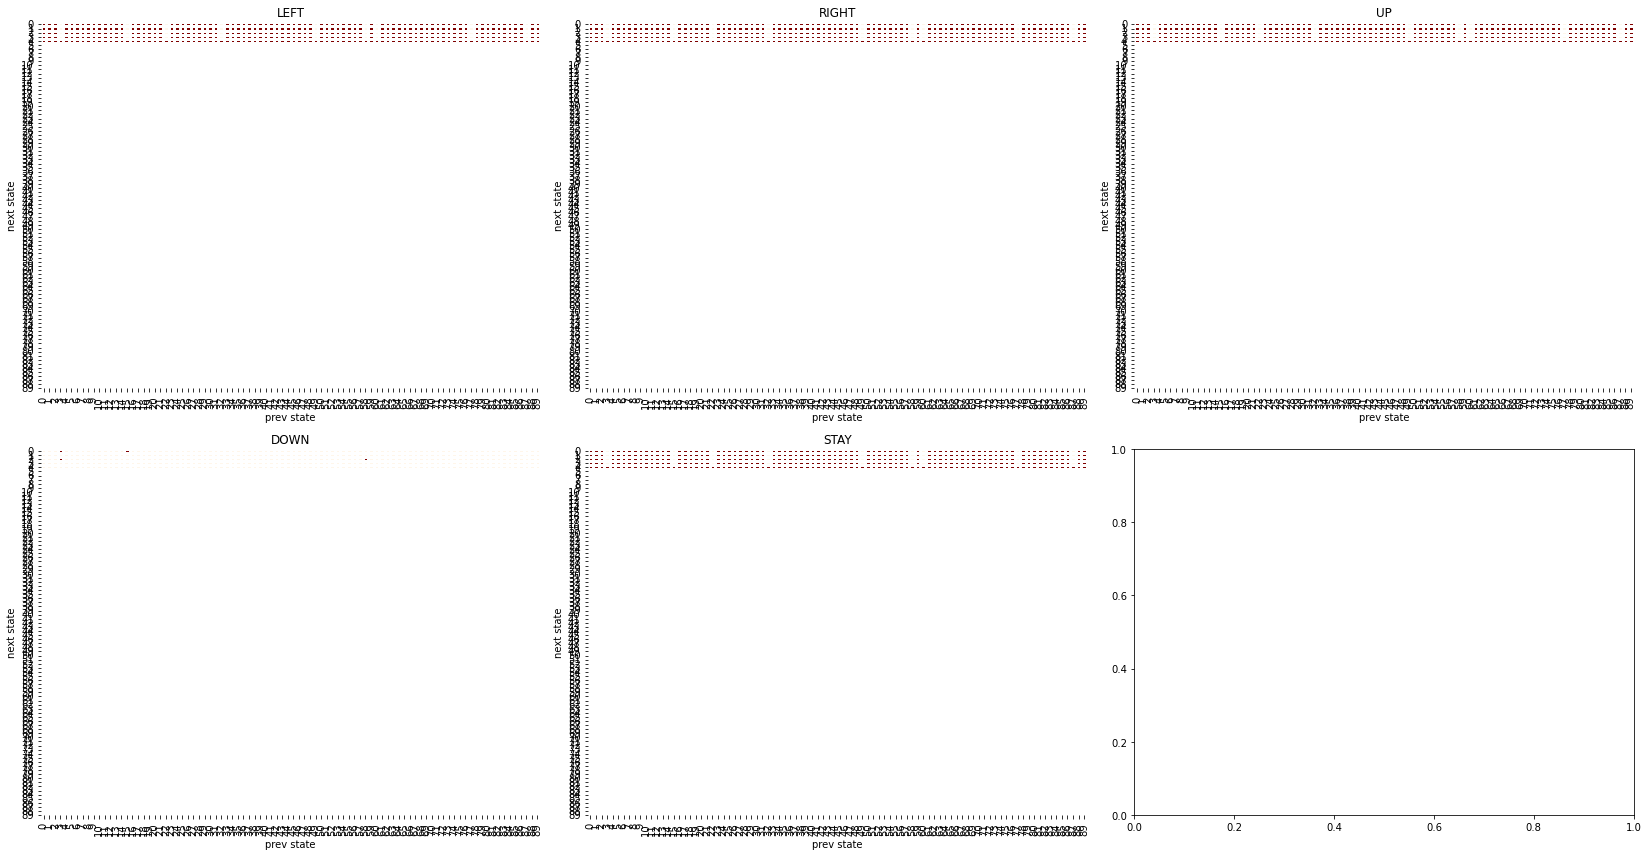

In [ ]:
print(chmm.T.shape)
print(chmm.agent.B[0].shape)

plot_transition(chmm.T, actions)

In [ ]:
from ours.pymdp import utils
from ours.pymdp.maths import spm_dot

def infer_action(chmm, **kwargs):
    obs=kwargs.get('obs',-1)
    next_possible_actions = kwargs.get('next_possible_actions',[*range(chmm.n_actions)])
    random = kwargs.get('random_policy', False)
    if random:
        return np.random.choice(next_possible_actions)
    
    prior = chmm.agent.qs[0].copy()
    if chmm.prev_action is not None:
        prior = spm_dot(chmm.agent.B[0][:, :, chmm.prev_action], prior)

    qs = chmm.agent.infer_states([obs])

    action = int(get_action(chmm,qs,next_possible_actions))

    chmm.prev_action = action

    chmm.agent.action = np.array([chmm.prev_action])
    chmm.agent.step_time()

    posterior = chmm.agent.qs[0].copy()
    return action, {
        "qs": chmm.agent.qs[0],
        "bayesian_surprise": utils.bayesian_surprise(posterior, prior),
        }

def get_action(chmm, qs,next_possible_actions):
    # states = np.where(qs[0][:-1] > 1e-4)[0]
    states = np.where(qs[0] > 1e-4)[0]
    pq = qs[0][states]

    plans = []
    n_states = []
    for i, s in enumerate(states):
        # pi_x = np.zeros_like(qs[0][:-1])
        pi_x = np.zeros_like(qs[0])
        pi_x[s] = 1
        #if s not in chmm.preferred_states:
        #if s in chmm.states:
        actions, states = observation_bridge(chmm, pi_x, max_steps=15) #consider preference
    
        if actions[0] == -1:
            pq[i] = 0
        elif states[0] in chmm.states:
            pq[i] = pq[i] * 1.5
        # else:
        #     actions = [-1]  # just go forward if its already in preferred
        #     states = [-1]
        #     pq[i] = 0

        plans.append(actions[0])
        n_states.append(states[0])

    norm = pq.sum() 
    print('plan', plans,'n_states',n_states, 'pq', pq)
    # if norm <= 0:
    #     pq = [1/len(pq)]*len(pq)
    #     action = np.random.choice(next_possible_actions)
    # else:
    pq /= norm
    action = np.random.choice(plans, p=pq)
    return action

def observation_bridge(chmm, belief_over_states, max_steps=100):
    
    # T = chmm.T[:, v][:, :, v][:, :, :]
    ret = forward_mp_all_multiple_states(
        chmm.T.transpose(0, 2, 1),
        belief_over_states,
        chmm.Pi_a,
        chmm.n_clones,
        chmm.preferred_states,
        max_steps,
    )
    
    if ret:
        print('belief_over_states',np.argmax(belief_over_states),'pref state', ret[2] ,'mess_fwd' ,ret[1]  )
        log2_lik, mess_fwd, selected_state = ret
        s_a = backtrace_all(
            chmm.T, chmm.Pi_a, chmm.n_clones, mess_fwd, selected_state
        )
        print('s_a',s_a)
        return s_a
    return [-1], [-1]
    


def backtrace_all(T, Pi_a, n_clones, mess_fwd, target_state):
    """Compute backward messages."""
    states = np.zeros(mess_fwd.shape[0], dtype=np.int64)
    actions = np.zeros(mess_fwd.shape[0], dtype=np.int64)
    n_states = T.shape[1]
    # backward pass
    t = mess_fwd.shape[0] - 1
    actions[t], states[t] = (
        -1,
        target_state,
    )  # last actions is irrelevant, use an invalid value
    for t in range(mess_fwd.shape[0] - 2, -1, -1):
        belief = (
            mess_fwd[t].reshape(1, -1) * T[:, :, states[t + 1]] * Pi_a.reshape(-1, 1)
        )
        a_s = rargmax(belief.flatten())
        actions[t], states[t] = a_s // n_states, a_s % n_states
    return actions, states


def forward_mp_all_multiple_states(
    T_tr, Pi_x, Pi_a, n_clones, target_states, max_steps
):
    """Log-probability of a sequence, and optionally, messages"""
    # forward pass
    t, log2_lik = 0, []
    message = Pi_x
    p_obs = message.max()
    assert p_obs > 0
    message /= p_obs
    log2_lik.append(np.log2(p_obs))
    mess_fwd = []
    mess_fwd.append(message)
    T_tr_maxa = (T_tr * Pi_a.reshape(-1, 1, 1)).max(0)
    selected_state = -1
    for t in range(1, max_steps):
        message = (T_tr_maxa * message.reshape(1, -1)).max(1)
        print('message high states', np.where(message > 0.1))
        p_obs = message.max()
        print('t',t, 'message', p_obs, message)
        if p_obs > 0:
            message /= p_obs
            log2_lik.append(np.log2(p_obs))
            mess_fwd.append(message)
            break_out = False
            print('message high states', np.where(message > 0.2), np.any(message != [message[0]]*len(message)))
            for target_state in target_states:
                
                #if target state reached if possible next state AND if the proba is not equally distributed among ALL states
                if message[target_state] > 0 : 
                    selected_state = target_state
                    break_out = True
                    print('break out', selected_state)
                    break
            if break_out:
                break
        else:
            return False

    else:
        return False
    return np.array(log2_lik), np.array(mess_fwd), selected_state

def rargmax(x):
    # return x.argmax()  # <- favors clustering towards smaller state numbers
    return np.random.choice((x == x.max()).nonzero()[0])

In [ ]:
def goal_reached(model, action , c_obs, p_obs, actions):
    if (c_obs[-1] == model.preferred_ob[0] and action == actions['STAY']) :
        print('Goal reached')
        return 1
    elif np.array_equal([model.preferred_ob[0]] * 3,c_obs[-3:]) and np.array_equal([p_obs[-1]]*3 ,p_obs[-3:]):
        print('Goal reached')
        return 2
    return 0


In [ ]:
#CSCG GOAL 
# chmm = load_object("figures/cscg/cscg_test.pkl")

chmm.goal_oriented_navigation(obs = preferred_ob.copy())
ob = env.reset((0,0))
print('start ob', ob)
x, a = [np.array([ob],dtype=np.int64), np.array([], dtype=np.int64)]
poses = [start_pose]
pose = start_pose
T = 15
for t in range(0,T):
    print()
    print('my t', t)
    next_possible_actions = env.get_next_possible_motions(pose, no_stay=False)
    print('p next actions', pose, next_possible_actions)
    # next_possible_actions = [0,1,2,3,4]
    action, _ = chmm.infer_action(obs=ob, random_policy=False)
    print('pose', pose, 'action chosen:', action)
    ob, pose = env.step(action, pose)
    x =np.append(x,ob)
    a= np.append(a,action)
    poses.append(pose)

    if goal_reached(chmm, action , x, poses, actions) >0:
        break

start ob 0

my t 0
p next actions (0, 0) [1, 3, 4]
pose (0, 0) action chosen: 0

my t 1
p next actions (0, 0) [1, 3, 4]
pose (0, 0) action chosen: 0

my t 2
p next actions (0, 0) [1, 3, 4]
pose (0, 0) action chosen: 0

my t 3
p next actions (0, 0) [1, 3, 4]
pose (0, 0) action chosen: 0

my t 4
p next actions (0, 0) [1, 3, 4]
pose (0, 0) action chosen: 0

my t 5
p next actions (0, 0) [1, 3, 4]
pose (0, 0) action chosen: 0

my t 6
p next actions (0, 0) [1, 3, 4]
pose (0, 0) action chosen: 0

my t 7
p next actions (0, 0) [1, 3, 4]
pose (0, 0) action chosen: 0

my t 8
p next actions (0, 0) [1, 3, 4]
pose (0, 0) action chosen: 0

my t 9
p next actions (0, 0) [1, 3, 4]
pose (0, 0) action chosen: 0

my t 10
p next actions (0, 0) [1, 3, 4]
pose (0, 0) action chosen: 0

my t 11
p next actions (0, 0) [1, 3, 4]
pose (0, 0) action chosen: 0

my t 12
p next actions (0, 0) [1, 3, 4]
pose (0, 0) action chosen: 0

my t 13
p next actions (0, 0) [1, 3, 4]
pose (0, 0) action chosen: 0

my t 14
p next act

<AxesSubplot:>

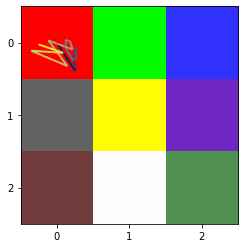

In [ ]:
plot_path_in_map(env, start_pose, a[:])